In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# from skfeature.function.similarity_based import fisher_score
import warnings
# warnings.filterwarnings('ignore')
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

# EDA

In [16]:
df = pd.read_csv('OnlineNewsPopularity.csv')
df.head()
#Check Nullity
df.isnull().sum() #It appears that the data has no null values
#For ' n_tokens_content', if it is 0, it means that the artitle is empty, therefore, let's remove those rows
print(df.shape)
df = df[df[' n_tokens_content'] != 0]
print(df.shape)
#Drop columns that are obbiously not going to be useful
df.drop(['url', ' timedelta', ' n_non_stop_words', ' n_non_stop_unique_tokens'], axis=1, inplace=True)

(39644, 61)
(38463, 61)


In [17]:
df.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000
mean,10.382419,563.295375,0.565049,11.217872,3.394769,4.563061,1.263786,4.687892,7.215012,0.054000,0.178249,0.162104,0.060084,0.190443,0.212360,26.708187,1151.751079,313.946906,13182.545563,750317.505135,255215.159411,1102.009897,5603.782810,3103.427793,4121.536513,10646.369414,6598.260636,0.168240,0.186439,0.187323,0.183345,0.143983,0.061592,0.069079,0.130671,0.188134,0.141680,0.217177,0.214291,0.238692,0.456984,0.122973,0.040842,0.017122,0.703096,0.296774,0.364689,0.098376,0.779963,-0.267493,-0.537970,-0.110801,0.280573,0.070997,0.342431,0.154930,3355.360398
std,2.113800,468.299538,3.573022,11.340580,3.869773,8.295365,4.164896,0.283231,1.916459,0.226021,0.382727,0.368551,0.237645,0.392655,0.408984,70.278215,3870.494630,624.449580,56850.480221,216395.888328,131821.240188,1127.031740,6096.725673,1301.238777,20026.792850,41612.149801,24553.836601,0.374084,0.389466,0.390176,0.386954,0.351077,0.240416,0.253592,0.337045,0.265547,0.220360,0.282238,0.288938,0.291382,0.088386,0.096091,0.016229,0.010588,0.150208,0.150032,0.085455,0.070382,0.212509,0.121174,0.279703,0.094919,0.323561,0.264338,0.188606,0.225636,11585.968776
min,2.000000,18.000000,0.114964,0.000000,0.000000,0.000000,0.000000,3.600000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.393750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,9.000000,259.000000,0.477419,5.000000,1.000000,1.000000,0.000000,4.496250,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,445.000000,143.000000,0.000000,843300.000000,171300.000000,0.000000,3549.290325,2373.807082,703.000000,1200.000000,1100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025060,0.025012,0.028572,0.025622,0.028575,0.402457,0.064394,0.029463,0.010177,0.612903,0.200000,0.311880,0.050000,0.600000,-0.331532,-0.714286,-0.125000,0.000000,0.000000,0.166667,0.000000,945.000000
50%,10.000000,423.000000,0.542986,8.000

In [18]:
#25 Percentile
print(df[' shares'].quantile(q=0.25))

#50 Percentile
print(df[' shares'].quantile(q=0.50))

#75 Percentile
print(df[' shares'].quantile(q=0.75))


945.0
1400.0
2700.0


In [19]:
#Convert ' share' to categorical
# <25 percentile: poor, 25-75 percentile: average, 75-100 percentile: good
print(df.shape)
share_label = list()
for share in df[' shares']:
        
    if share <= 946:
        share_label.append(0)#Very Poor
    elif share > 946 and share <= 1400:
        share_label.append(1)#Poor
    elif share >1400 and share <= 2800:
        share_label.append(2)#Above Average
    else:
        share_label.append(3)#Good
        
        

# Update this class label into the dataframe
df['popularity'] = share_label


(38463, 57)


In [20]:
#Some of the features are related to each other such as ' weekday_is_monday' and ' weekday_is_tuesday' and ' data_channel_is_lifestyle' and ' data_channel_is_entertainment'. This violates non-multicollinearity of model such as linear regression
#Merging 
dayMerge = df[[' weekday_is_monday',' weekday_is_tuesday',' weekday_is_wednesday',' weekday_is_thursday',' weekday_is_friday',' weekday_is_saturday',' weekday_is_sunday', ]]
day_arr = []
for r in list(range(dayMerge.shape[0])):
    for c in list(range(dayMerge.shape[1])):
        if ((c==0) and (dayMerge.iloc[r,c])==1):
            day_arr.append(0)
        elif ((c==1) and (dayMerge.iloc[r,c])==1):
            day_arr.append(1)
        elif ((c==2) and (dayMerge.iloc[r,c])==1):
            day_arr.append(2)
        elif ((c==3) and (dayMerge.iloc[r,c])==1):
            day_arr.append(3)
        elif ((c==4) and (dayMerge.iloc[r,c])==1):
            day_arr.append(4)
        elif ((c==5) and (dayMerge.iloc[r,c])==1):
            day_arr.append(5) 
        elif ((c==6) and (dayMerge.iloc[r,c])==1):
            day_arr.append(6)
            
channelMerge=df[[' data_channel_is_lifestyle',' data_channel_is_entertainment' ,' data_channel_is_bus',
                        ' data_channel_is_socmed' ,' data_channel_is_tech',' data_channel_is_world' ]]

channel_arr = []

for r in list(range(channelMerge.shape[0])):
    if (((channelMerge.iloc[r,0])==0) and ((channelMerge.iloc[r,1])==0) and ((channelMerge.iloc[r,2])==0) and ((channelMerge.iloc[r,3])==0) and ((channelMerge.iloc[r,4])==0) and ((channelMerge.iloc[r,5])==0)):
        channel_arr.append(6)
    for c in list(range(channelMerge.shape[1])):
        if ((c==0) and (channelMerge.iloc[r,c])==1):
            channel_arr.append(0)
        elif ((c==1) and (channelMerge.iloc[r,c])==1):
            channel_arr.append(1)
        elif ((c==2) and (channelMerge.iloc[r,c])==1):
            channel_arr.append(2)
        elif ((c==3) and (channelMerge.iloc[r,c])==1):
            channel_arr.append(3)
        elif ((c==4) and (channelMerge.iloc[r,c])==1):
            channel_arr.append(4)
        elif ((c==5) and (channelMerge.iloc[r,c])==1):
            channel_arr.append(5)
            
df.insert(loc=11, column='weekdays', value=day_arr)
df.insert(loc=12, column='data_channel', value=channel_arr)

df.drop(labels=[' data_channel_is_lifestyle',' data_channel_is_entertainment' ,' data_channel_is_bus',
                  ' data_channel_is_socmed' ,' data_channel_is_tech',' data_channel_is_world', 
                  ' weekday_is_monday',' weekday_is_tuesday',' weekday_is_wednesday', 
                  ' weekday_is_thursday', ' weekday_is_friday',' weekday_is_saturday' ,' weekday_is_sunday', ' shares'], axis = 1, inplace=True)

In [21]:
#Check Class Balance
class_counts = df.groupby('popularity').size().reset_index()
class_counts.columns = ['Popularity','No of articles']
print(class_counts)

weekdays_data = df.groupby('weekdays').size().reset_index()
weekdays_data.columns = ['weekdays','count']
print(weekdays_data)

channel_data = df.groupby('data_channel').size().reset_index()
channel_data.columns = ['data_channel','count']
print(channel_data)

   Popularity  No of articles
0           0            9661
1           1            9890
2           2            9660
3           3            9252
   weekdays  count
0         0   6471
1         1   7171
2         2   7205
3         3   7052
4         4   5538
5         5   2369
6         6   2657
   data_channel  count
0             0   2077
1             1   6856
2             2   6235
3             3   2311
4             4   7325
5             5   8168
6             6   5491


# Feature Selection

## L1 Feature Selection

In [8]:
#Attempting Lasso(L1) feature selection
# shares data is not needed for classification
X = df.drop(labels=['popularity'], axis = 1, inplace=False)
y = df['popularity']
X= pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)



# Standardize the train and test sample
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train)

# Perform GridSearchCV to tune best-fit LR model
param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}

lr_model = LogisticRegression(penalty='l1', solver='liblinear')
lr_model.fit(X_train, y_train)


print("Redundant Feature Count: ", sum(lr_model.coef_[0]==0))
print("Redundant Feature Names: ", list(pd.Series(X_train.columns)[list(lr_model.coef_[0]==0)]))


Redundant Feature Count:  2
Redundant Feature Names:  [' global_rate_positive_words', ' global_rate_negative_words']


In [63]:
df.drop(labels=[' global_rate_negative_words', ' avg_positive_polarity', ' global_sentiment_polarity', ' avg_negative_polarity', ' max_negative_polarity'], axis = 1, inplace=True)

## Fisher Score Feature Selection

In [22]:
# score = fisher_score.fisher_score(X_std, y_train)
# feat_importance = pd.Series(scores, X_std.colums[:])
# feat_importance.plot(kind='barh', color = 'teal')
# plt.show()
# print(score)
scaler = StandardScaler()
X = df.drop(labels=['popularity'], axis = 1, inplace=False)
y = df['popularity']
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
X_std = scaler.fit_transform(X_train)
from skfeature.function.similarity_based import fisher_score
ranks = fisher_score.fisher_score(X_std, y_train)
print(ranks)

/opt/anaconda3/lib/python3.8/site-packages/skfeature/utility/construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = class_idx[:, np.newaxis] & class_idx[np.newaxis, :]
/opt/anaconda3/lib/python3.8/site-packages/skfeature/utility/construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = class_idx[:, np.newaxis] & class_idx[np.newaxis, :]
/opt/anaconda3/lib/python3.8/site-packages/skfeature/utility/construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = class_idx[:, np.newaxis] & class_idx[np.newaxis, :]
/

[25 21 18 35 15 27 16 41 17 26 22 19 23 42 24 43 39 28 14 33 34 20 13  7
  2 10 11  5  6 44 29  0  9 36  3 12 37 38 31  8 40 32 30  1  4]


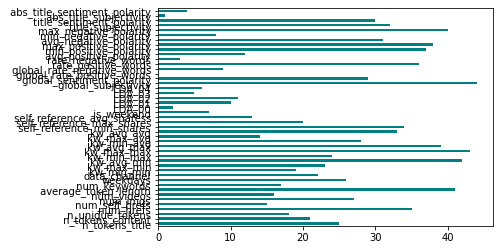

<Figure size 3600x3600 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
feat_importance = pd.Series(ranks, X.columns[0: len(X.columns)])
feat_importance.plot(kind='barh', color = 'teal')
fig = plt.figure() 
fig.set_size_inches(50, 50)
plt.show()

In [24]:
idx_lst = []
score_map = []
for idx, val in enumerate(ranks):
    if val < 5:
        idx_lst.append(idx)
        score_map.append((idx, val))
print(score_map)
print("Redundant Feature Names: ", list(pd.Series(X_train.columns)[idx_lst]))

[(24, 2), (31, 0), (34, 3), (43, 1), (44, 4)]
Redundant Feature Names:  [' LDA_00', ' global_rate_positive_words', ' rate_negative_words', ' abs_title_subjectivity', ' abs_title_sentiment_polarity']


In [25]:
df.drop(labels=list(pd.Series(X_train.columns)[idx_lst]), axis = 1, inplace=True)
df.drop(labels=[' global_rate_negative_words', ' avg_positive_polarity', ' global_sentiment_polarity', ' avg_negative_polarity', ' max_negative_polarity'], axis = 1, inplace=True)
# print(df.shape())

# Model Training

In [26]:
from sklearn.preprocessing import LabelEncoder
X_std = scaler.fit_transform(df)
df = pd.DataFrame(X_std, columns = df.columns[0: len(df.columns)])
X = df.drop(labels=['popularity'], axis = 1, inplace=False)
y = df['popularity']
labelEn = LabelEncoder()
y = labelEn.fit_transform(y)
# class_names = labelEn.classes_

X= pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

## Support Vector Machine

In [17]:
# svm = SVC(gamma='auto')
# svm.fit(X_train, y_train)

## Logistic Regression

In [18]:
# logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=7000)
# logistic_regression.fit(X_train, y_train)

## Random Forest

In [27]:
rf_classfication = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_depth=50,random_state=666)
rf_classfication.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, n_estimators=1000, n_jobs=-1,
                       random_state=666)

# Evaluation

In [15]:
#Evaluateing Logistic Regression
# y_pred = logistic_regression.predict(X_test)
# print("F1 Score: ",f1_score(y_test, y_pred, average='macro'))
#print("Accuracy: ",accuracy_score(y_test, y_pred))
#F1 Score:  0.31860939565338836

In [28]:
#Evaluating RF
y_pred = rf_classfication.predict(X_test)
print("F1 Score: ",f1_score(y_test, y_pred, average='macro'))
print("Accuracy: ",accuracy_score(y_test, y_pred))

F1 Score:  0.39138834317138865
Accuracy:  0.4006413034058411


In [17]:
#Evaluating SVM
# y_pred = svm.predict(X_test)
# print("F1 Score: ",f1_score(y_test, y_pred, average='macro'))
#print("Accuracy: ",accuracy_score(y_test, y_pred))
#F1 Score:  0.10067998398348055

# Conclusions and Findings